In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import random
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from google.colab import drive
import tensorflow as tf

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Fri Apr  5 20:12:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def set_seed(seed = 42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

In [ ]:
ROOT_PATH = '/content/gdrive/MyDrive/lgg-mri-segmentation/kaggle_3m/'

mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,1
1,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,1
2,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,0
3,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,0
4,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,0
...,...,...,...
3924,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,0
3925,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,0
3926,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,0
3927,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,/content/gdrive/MyDrive/lgg-mri-segmentation/k...,0


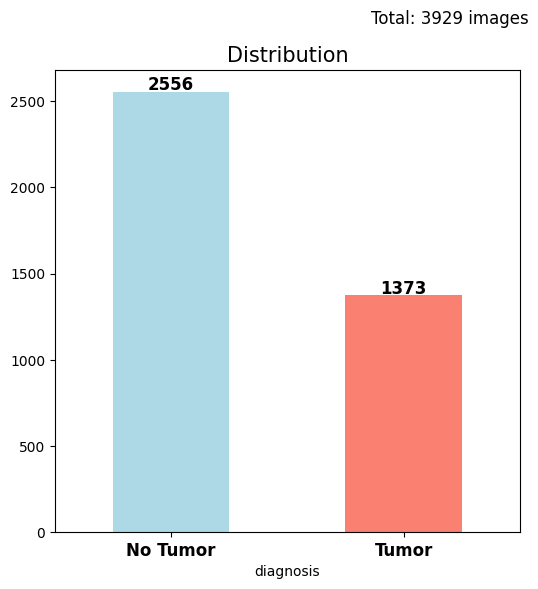

In [ ]:
colors = ['lightblue', 'salmon']

ax = files_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6, 6), color=colors)
ax.set_title('Distribution', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0, weight='bold')

for i, rows in enumerate(files_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows + 12), ha='center', fontweight='bold', fontsize=12)

total_cases_text = f"Total: {len(files_df)} images"
ax.text(0.85, 1.1, total_cases_text, ha='center', fontsize=12, transform=ax.transAxes)

plt.show()

In [ ]:
set_seed()

K = 5

test_size = int(len(files_df) * 0.2)
val_size = int(len(files_df) * 0.2)

folds = []

possible_indices = list(range(len(files_df)))
possible_indices_original = list(range(len(files_df)))

for k in range(K):
    test_indices = np.random.choice(possible_indices, test_size, replace=False)

    possible_indices_val = [i for i in possible_indices_original if i not in test_indices]

    val_indices = np.random.choice(possible_indices_val, val_size, replace=False)

    train_indices = [i for i in possible_indices_val if i not in val_indices]

    fold = {
        'train_indices': train_indices,
        'val_indices': val_indices,
        'test_indices': test_indices
    }
    folds.append(fold)


    possible_indices = [i for i in possible_indices if i not in test_indices]

#print("First fold:", folds[1])

test_set_indices = set()
for fold in folds:
    test_set_indices.update(fold['test_indices'])

all_indices = set(range(len(files_df)))
indices_not_in_test_set = all_indices - test_set_indices

print("Indices not in the test set:", indices_not_in_test_set)
print("Remained out: ", len(indices_not_in_test_set))

Indices not in the test set: {1102, 28, 294, 1038}
Remained out:  4


In [ ]:
indices_not_in_test_set = list(indices_not_in_test_set)

for idx in indices_not_in_test_set:
    folds[0]['test_indices'] = np.append(folds[0]['test_indices'], idx)

print("Updated Test Indices:", folds[0]['test_indices'])


Updated Test Indices: [1835 1490 2063 1178 3749 1338 2289 1448 3229 1075  354 2325  893 2351
 2506 2118  670 1791   14 1377 3872 1627 1391 1602 2119 1503 3232 2880
  270 3121  721 1647 1188  166 3452 3372 1084 3656 1688  196 2282 1779
  948 1422 2685 2542  785   32   70 3905 1029 1146 2817 1057 3488  802
 1653 3820  842 2456 3908 3133 3839  657  952 1747 1064 2891 1313 2345
 1006 3335 1728 3875 2370 1689  149 2381  179 2679 3424  551 2392 1684
 2148 3151 3780 2725 1138 1590 1966 3476  857 1812 2815 3524  240 1921
 2603 1011 1255 2611 1322 3673 1228  501 2344 3349 3412 2741 3812  818
 1406 3280  211 2636  457 2144 1431 1221 3416 1424 3916  229 3479 3204
 1211    8 2921 2423 3537  325  402  463 2821  949  410 2943 1017  594
 2661 1132  432 1222 1034  567 2517   93 3155  393 2421 2387 2020 3455
 2319 2664 3260 3793  321 1128 2522 3743 1113 2898 1569  805 3521 1426
 2726  318 2164 2290  803 1097 1926  544 3007 1869 3698 2077  156 2411
  120 3135 2177 2760 2206  573 1808 1370 1204 1149 3738

In [ ]:
print(len(set(files_df.index)
          - set(folds[0]["test_indices"])
          - set(folds[1]["test_indices"])
          - set(folds[2]["test_indices"])
          - set(folds[3]["test_indices"])
          - set(folds[4]["test_indices"])))

0


In [ ]:
test_overlapping = set(folds[0]["test_indices"]) & set(folds[1]["test_indices"]) & set(folds[2]["test_indices"]) & set(folds[3]["test_indices"]) & set(folds[4]["test_indices"])
print("Numbers of overlapping:", test_overlapping)

Numbers of overlapping: set()


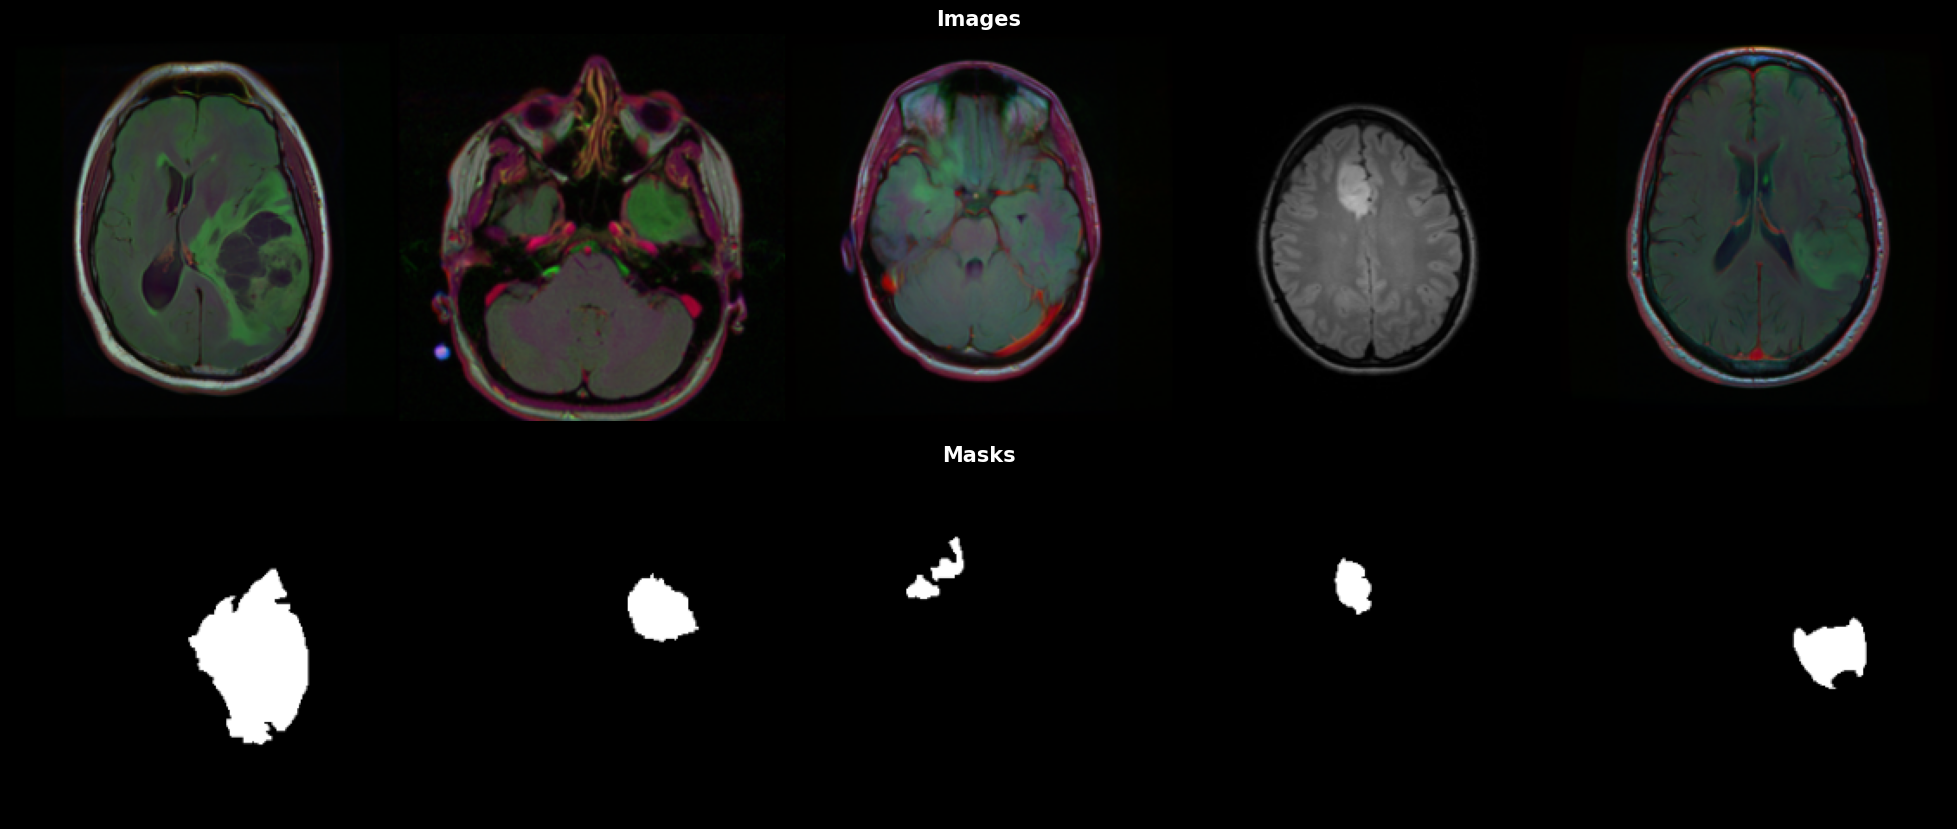

In [ ]:
sample_df = files_df[files_df["diagnosis"] == 1].sample(5)
sample_imgs = []
IMG_SIZE = (224, 224)

set_seed(0)
for i, (_, sample_data) in enumerate(sample_df.iterrows()):
    img = cv2.resize(cv2.imread(sample_data["image_path"]), IMG_SIZE)
    mask = cv2.resize(cv2.imread(sample_data["mask_path"]), IMG_SIZE)
    sample_imgs.extend([img, mask])

sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

fig = plt.figure(figsize=(25., 25.), facecolor="black")
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 1),
                 axes_pad=0.1,
                 )

grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15, color="white", weight="bold")
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9, color="white", weight="bold")
grid[1].axis("off")

plt.show()

In [ ]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

In [ ]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

In [ ]:
set_seed()

train_datasets = []
val_datasets = []
test_datasets = []

for fold_idx, fold in enumerate(folds):
    train_indices = fold['train_indices']
    val_indices = fold['val_indices']
    test_indices = fold['test_indices']

    train_df = files_df.iloc[train_indices]
    val_df = files_df.iloc[val_indices]
    test_df = files_df.iloc[test_indices]

    train_ds = BrainDataset(train_df, train_transform)
    val_ds = BrainDataset(val_df, val_transform)
    test_ds = BrainDataset(test_df, test_transform)

    train_datasets.append(train_ds)
    val_datasets.append(val_ds)
    test_datasets.append(test_ds)


In [ ]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [ ]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

total_len = len(train_ds) + len(val_ds) + len(test_ds)
print("Total count:", total_len)

Train dataset:
Size of dataset: 2359
Sample-8 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 785
Sample-6 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 785
Sample-15 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Total count: 3929


In [ ]:
batch_size = 64

set_seed()
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

set_seed()
val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

test_dl = DataLoader(test_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 1, 128, 128])


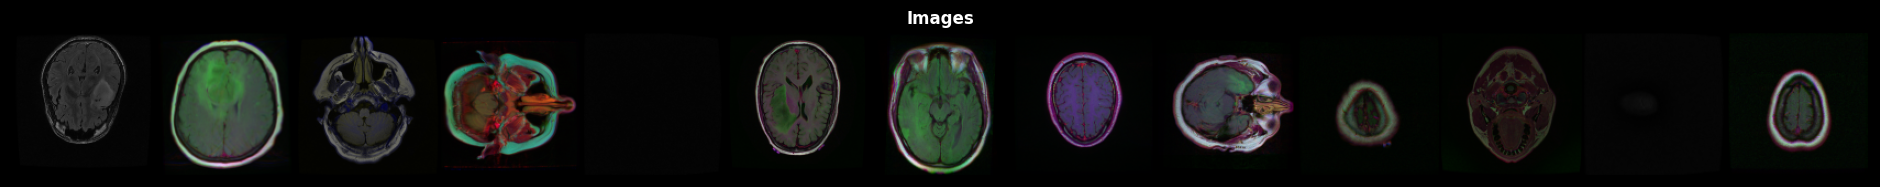

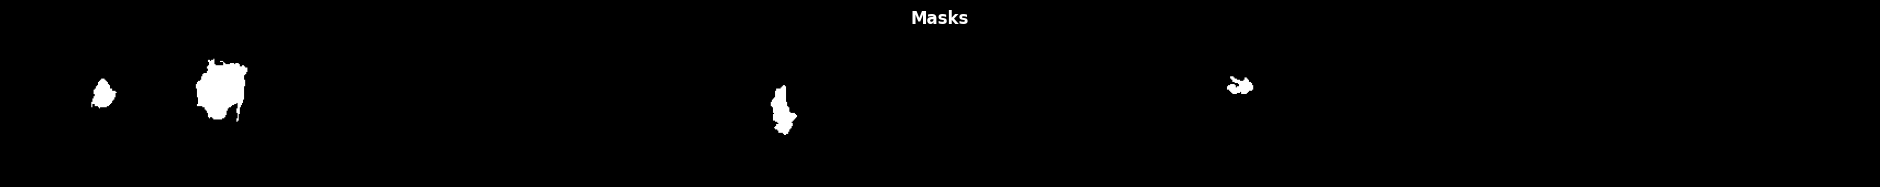

In [ ]:
def denormalize(images):
    means = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    return images * stds + means

set_seed()
def show_batch(dl):
    for images, masks in dl:
        fig1, ax1 = plt.subplots(figsize=(24, 24), facecolor="black")
        ax1.set_xticks([]); ax1.set_yticks([])
        denorm_images = denormalize(images)
        ax1.imshow(make_grid(denorm_images[:13], nrow=13).permute(1, 2, 0).clamp(0,1))
        ax1.set_title("Images", fontsize=12, color="white", weight="bold")

        fig2, ax2 = plt.subplots(figsize=(24, 24), facecolor="black")
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[:13], nrow=13).permute(1, 2, 0).clamp(0,1), cmap="gray")
        ax2.set_title("Masks", fontsize=12, color="white", weight="bold")
        break

show_batch(train_dl)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

model = UNet(3, 1)
out = model(torch.randn(1, 3, 128, 128))
print(out.shape)

torch.Size([1, 1, 128, 128])


In [ ]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

def dice_sc(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def calculate_metrics(data_loader, model):
    model.eval()
    intersection = 0
    union = 0
    total_samples = 0

    with torch.no_grad():
        for image, mask in data_loader:
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            pred_mask = (outputs > 0.5).float()  # Convert to binary mask

            intersection += (pred_mask * mask).sum().item()
            union += (pred_mask + mask).sum().item()
            total_samples += image.size(0)

    dice = 2.0 * intersection / (union + 1e-8)  # Add a small epsilon to avoid division by zero
    iou = intersection / (union - intersection + 1e-8)  # Add a small epsilon to avoid division by zero

    return dice, iou



## Training

In [ ]:
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []

    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_dices, train_losses

In [ ]:
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = loss_func(outputs, mask)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step

        if training:
            scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss

In [ ]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)

        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)

        print('Epoch: {}/{} |  Train Loss: {:.3f}, Validation Loss: {:.3f}, Train DICE: {:.3f}, Validation DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                  train_mean_loss,
                                                                                                                  val_mean_loss,
                                                                                                                  train_mean_dice,
                                                                                                                  val_mean_dice))


    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [ ]:
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Cross Validation

In [ ]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold_idx, fold in enumerate(folds[:3]):
    print(f"Fold {fold_idx + 1}/{K}:")

    model = UNet(3,1)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

    train_indices = fold['train_indices']
    val_indices = fold['val_indices']
    test_indices = fold['test_indices']

    train_df = files_df.iloc[train_indices]
    val_df = files_df.iloc[val_indices]
    test_df = files_df.iloc[test_indices]

    train_ds = BrainDataset(train_df, train_transform)
    val_ds = BrainDataset(val_df, val_transform)
    test_ds = BrainDataset(test_df, test_transform)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=True)

    print("Size of train dataset:", len(train_ds))
    print("Size of validation dataset:", len(val_ds))

    train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
        train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2, pin_memory=True)
    test_mean_dice, test_mean_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)

    # Calculate DSC and IoU for the test set
    test_dsc, test_iou = calculate_metrics(test_dl, model)

    print("Size of test dataset:", len(test_ds))
    print(f"Test Loss: {test_mean_loss:.3f}, Test DICE: {test_mean_dice:.3f}")
    print(f"Test DSC: {test_dsc:.4f}, Test IoU: {test_iou:.4f}\n")

Fold 1/5:
Size of train dataset: 2359
Size of validation dataset: 785
Epoch: 1/5 |  Train Loss: 1.321, Validation Loss: 82.643, Train DICE: 0.352, Validation DICE: 0.021
Epoch: 2/5 |  Train Loss: 1.072, Validation Loss: 1.190, Train DICE: 0.495, Validation DICE: 0.286
Epoch: 3/5 |  Train Loss: 0.922, Validation Loss: 0.936, Train DICE: 0.566, Validation DICE: 0.657
Epoch: 4/5 |  Train Loss: 0.744, Validation Loss: 0.793, Train DICE: 0.615, Validation DICE: 0.651
Epoch: 5/5 |  Train Loss: 0.569, Validation Loss: 1.451, Train DICE: 0.643, Validation DICE: 0.089
Size of test dataset: 789
Test Loss: 1.446, Test DICE: 0.106
Test DSC: 0.0927, Test IoU: 0.0486

Fold 2/5:
Size of train dataset: 2359
Size of validation dataset: 785
Epoch: 1/5 |  Train Loss: 1.345, Validation Loss: 1.485, Train DICE: 0.383, Validation DICE: 0.512
Epoch: 2/5 |  Train Loss: 1.097, Validation Loss: 1.126, Train DICE: 0.559, Validation DICE: 0.680
Epoch: 3/5 |  Train Loss: 0.938, Validation Loss: 0.979, Train DICE: 

In [ ]:
%%time
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

Saving the model

In [ ]:
torch.save(model.state_dict(), 'trained_UNet_model.pth')

In [ ]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 5))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="g")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Number of Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.xticks(np.arange(0, num_epochs + 1, 1))

    plt.show()

plot_dice_history('UNET Architecture', train_dice_history, val_dice_history, num_epochs)

In [ ]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 5))

    train_loss_history_cpu = [loss.item() for loss in train_loss_history]
    val_loss_history_cpu = [loss.item() for loss in val_loss_history]

    plt.plot(x, train_loss_history_cpu, label='Train Loss', lw=3, c="b")
    plt.plot(x, val_loss_history_cpu, label='Validation Loss', lw=3, c="g")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Number of Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.xticks(np.arange(0, num_epochs + 1, 1))

    plt.show()

plot_loss_history('UNET Architecture', train_loss_history, val_loss_history, num_epochs)

In [ ]:
set_seed()

test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(8, 8), facecolor="black")

ax[0, 0].imshow(image)
ax[0, 0].set_title("Image", color="white")
ax[0, 0].tick_params(axis='both', colors='white')

ax[0, 1].imshow(mask)
ax[0, 1].set_title("Mask", color="white")
ax[0, 1].tick_params(axis='both', colors='white')

ax[1, 0].imshow(pred)
ax[1, 0].set_title("Prediction", color="white")
ax[1, 0].tick_params(axis='both', colors='white')

ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("Prediction with threshold", color="white")
ax[1, 1].tick_params(axis='both', colors='white')

plt.show()